In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sqlalchemy.orm import Query
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.auto import tqdm
from transformers import AutoTokenizer
from transformers import logging

import src.db.connect
import src.db.models.bert_data as bm
from src.bert.module import BertMultiTaskClassification

In [ ]:
logging.set_verbosity_error()
torch.manual_seed(0)

pd.set_option("display.max_colwidth", 2048)
pd.set_option("display.max_rows", 128)

# model hyper-parameters
LR = 1e-5
N_EPOCHS = 4
BATCH_SIZE = 16

TOKENIZER = "deepset/gbert-large"
MODEL = "deepset/gbert-large"
# MODEL = str(src.PATH / "tmp/l")

DEVICE = "cuda"

engine = src.db.connect.make_engine("DB")

In [ ]:
class PBertDataset(Dataset):
    def __init__(self, df: pd.DataFrame, valid_coders: list[str]):
        self.df = df
        self.valid_coders = valid_coders

    @classmethod
    def from_db(cls, engine, exclude_coders=[]):
        valid_coders = [
            "grabsch",
            "schadt",
            "richter",
            "riedel",
            "coudry",
        ]

        for excl in exclude_coders:
            valid_coders.remove(excl)

        query = (
            Query(bm.Label)
            .join(bm.Sample)
            .with_entities(
                bm.Label.sample_id.label("id"),
                bm.Sample.text,
                bm.Label.username,
                bm.Label.pop_antielite.label("elite"),
                bm.Label.pop_pplcentr.label("centr"),
            )
            .filter(bm.Label.username.in_(valid_coders))
        )

        with engine.connect() as conn:
            df = pd.read_sql(query.statement, conn)

        df["labels"] = df.apply(cls.set_labels, axis=1)
        # df = df[df.labels != -1]

        # filter all samples that are not coded by every coder
        df = df.groupby(["id", "text"]).filter(lambda x: len(x) == len(valid_coders))

        # aggregate codings
        df = df.groupby(["id", "text"])["labels"].agg(tuple).reset_index()

        df["vote"] = df.labels.apply(cls.majority_vote)

        return cls(df, valid_coders)

    @staticmethod
    def set_labels(row):
        if row["centr"] == 1 and row["elite"] == 1:
            return 2
        elif row["elite"] == 1:
            return 1
        elif row["centr"] == 1:
            return 2
        else:
            return 0

    def train_test_split(self, test_size=0.3):
        train, test = train_test_split(
            self.df,
            test_size=test_size,
            random_state=1337,
            shuffle=True,
            stratify=self.df.vote,
        )

        return (
            PBertDataset(df=train, valid_coders=self.valid_coders),
            PBertDataset(df=test, valid_coders=self.valid_coders),
        )

    def __len__(self):
        return len(self.df)

    @property
    def num_labels(self):
        return self.df.vote.nunique()

    @property
    def num_coders(self):
        return len(self.valid_coders)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {"text": row.text, "labels": row.labels, "vote": row.vote}

    @staticmethod
    def majority_vote(votes):
        values, counts = np.unique(votes, return_counts=True)
        majority_vote = values[counts.argmax()]
        return majority_vote

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER)

dataset = PBertDataset.from_db(
    engine,
    exclude_coders=["grabsch", "schadt"],
)

train, test = dataset.train_test_split()

In [ ]:
def collate(batch):
    global tokenizer
    encoding = tokenizer([d["text"] for d in batch], padding=True, return_tensors="pt")

    labels = [d["labels"] for d in batch]
    labels = torch.Tensor(labels).to(DEVICE)

    votes = torch.Tensor([d["vote"] for d in batch]).to(DEVICE)

    return {
        "encodings": encoding.to(DEVICE),
        "text": [d["text"] for d in batch],
        "labels": torch.Tensor([d["labels"] for d in batch]).to(DEVICE),
        "vote": [d["vote"] for d in batch],
    }

In [ ]:
data_loader = {
    "train": DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate),
    "test": DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate),
}

In [ ]:
len(train), len(test)

(4106, 1761)

In [ ]:
test[33]

{'text': 'Deswegen wollen wir mit unserem Gesetzentwurf, den wir Ihnen vorlegen, dass der Bundesdatenschutzbeauftragte das, was die sogenannte JI-Richtlinie vorsieht, auch machen kann, nämlich dass er bei der Polizei und der Justiz beispielsweise Eingriffsbefugnisse hat und handeln kann.',
 'labels': (0, 0, 0),
 'vote': 0}

In [ ]:
model = BertMultiTaskClassification(
    name=MODEL,
    tasks=dataset.num_coders,
    num_labels=dataset.num_labels,
    freeze_bert=False,
)

model = model.to(DEVICE)
model = model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


n_batches = len(train) // BATCH_SIZE
print("epoch" + " " * 7 + "loss" + " " * 7 + "acc" + " " * 7 + "f1_macro")
print("-" * 45)

for epoch in range(N_EPOCHS):
    epoch_loss = 0
    y_pred = []
    y_true = []
    for batch in tqdm(data_loader["train"], total=n_batches, leave=False):
        loss, probas = model(**batch["encodings"], labels=batch["labels"])
        epoch_loss += loss

        probas = probas.to("cpu").detach().numpy()
        for prob in probas:
            votes = np.argmax(prob, axis=1)
            values, counts = np.unique(votes, return_counts=True)
            major_vote = values[counts.argmax()]
            y_pred.append(major_vote)

        y_true.extend(batch["vote"])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_acc = round(accuracy_score(y_true, y_pred), 3)
    macro_f1 = round(f1_score(y_true, y_pred, average="macro"), 3)
    epoch_loss = round(float(epoch_loss.to("cpu").detach()), 3)

    print(f"{epoch + 1:<10} {round(epoch_loss, 3):<11} {train_acc:<10} {macro_f1:<10}")

epoch       loss       acc       f1_macro
---------------------------------------------


  0%|          | 0/256 [00:00<?, ?it/s]

1          447.951     0.806      0.478     


  0%|          | 0/256 [00:00<?, ?it/s]

2          344.632     0.853      0.641     


  0%|          | 0/256 [00:00<?, ?it/s]

3          291.982     0.875      0.718     


  0%|          | 0/256 [00:00<?, ?it/s]

4          247.495     0.906      0.8       


In [ ]:
model = model.eval()

batches = len(test) // BATCH_SIZE

results = []
for batch in tqdm(data_loader["test"], total=batches, leave=False):
    _, probas = model(**batch["encodings"])

    probas = probas.to("cpu").detach().numpy()

    for i, prob in enumerate(probas):
        votes = np.argmax(prob, axis=1)
        values, counts = np.unique(votes, return_counts=True)
        major_vote = values[counts.argmax()]

        result = {
            "text": batch["text"][i],
            "true_labels": batch["labels"][i].to("cpu").detach().numpy().astype(int),
            "pred_labels": votes,
            "true_vote": batch["vote"][i],
            "pred_vote": major_vote,
        }

        results.append(result)

results = pd.DataFrame(results)

  0%|          | 0/110 [00:00<?, ?it/s]

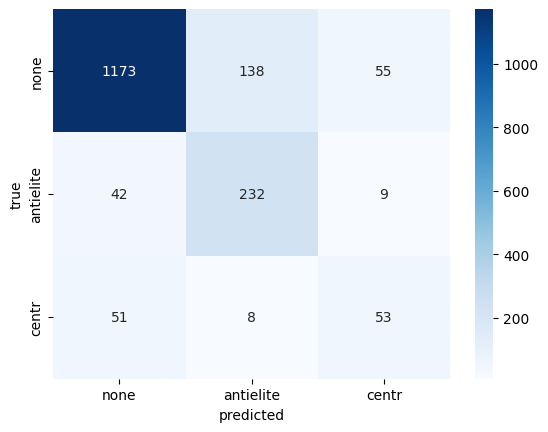

In [ ]:
conf_mat = pd.DataFrame(confusion_matrix(results.true_vote, results.pred_vote))

fig = sns.heatmap(conf_mat, annot=True, fmt=".4g", cmap="Blues")
ticklabels = ["none", "antielite", "centr"]
fig.set_xticklabels(ticklabels)
fig.set_yticklabels(ticklabels)
fig.set_ylabel("true")
fig.set_xlabel("predicted")

plt.show()

In [ ]:
print(classification_report(results.true_vote, results.pred_vote, zero_division=0))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1366
           1       0.61      0.82      0.70       283
           2       0.45      0.47      0.46       112

    accuracy                           0.83      1761
   macro avg       0.66      0.72      0.69      1761
weighted avg       0.85      0.83      0.83      1761



In [ ]:
pd.set_option("display.max_rows", 2048)

In [ ]:
# results[(results.true_vote == 0) & (results.pred_vote == 2)]
results.sample(75)

,text,true_labels,pred_labels,true_vote,pred_vote
425,"Die Kommunen sind Motor bei der Energiewende, sie sind Multiplikator.","[0, 0, 0]","[0, 0, 0]",0,0
2,Das ist bedauerlich.,"[0, 0, 0]","[0, 0, 0]",0,0
720,Berlin ist nach London der Start-up-Platz Nummer zwei in Europa.,"[0, 0, 0]","[0, 0, 0]",0,0
1005,"Er steht ziemlich weit in der Mitte. – Denn die AfD wirft ihm vor, dass er aus ideologischen Gründen das Auto verrät, und die Grünen sagen, dass er aus ideologischen Gründen den Götzenkult ums Auto weiter fortführt.","[0, 0, 0]","[0, 1, 1]",0,1
352,"Meine Fraktion, die Fraktion der Freien Demokraten, und, ich denke, auch die allermeisten Mitglieder dieses Hauses möchten keinem Menschen in Afrika sagen müssen, dass wir sein Kind nicht gerettet haben, nicht, weil wir es nicht konnten, sondern, weil wir es nicht wollten – so, wie es die AfD beantragt.","[1, 0, 0]","[0, 0, 0]",0,0
224,"Damit erreichen wir sehr viel, indem dieses sogenannte Durcheinander sortiert, reguliert und reduziert wird.","[0, 0, 0]","[0, 0, 0]",0,0
1140,"Es geht um Rechte und um Pflichten sowie um das eigene Bemühen und nicht darum, Erwerbslose unter Generalverdacht zu stellen, wie es uns die Fraktion","[0, 0, 0]","[0, 0, 0]",0,0
1115,"Es müsste doch auch den linken Ideologen so langsam dämmern, dass man mit Mietpreissozialismus kein einziges Problem wirklich nachhaltig lösen kann.","[0, 1, 0]","[1, 1, 1]",0,1
41,"So gehen seit Monaten junge Menschen gegen Korruption, Misswirtschaft und auch gegen die politische Klasse auf die Straße.","[0, 0, 0]","[0, 0, 0]",0,0
611,"Hier haben wir jetzt insbesondere durch das Entdeckungsrisiko und auch - da gebe ich Ihnen recht, Frau Wagenknecht - durch die Drohung der amerikanischen Regierung, den europäischen Banken die Lizenz zu entziehen, wenn sie die Kontodaten amerikanischer Staatsbürger nicht herausrücken - das sogenannte FATCA-Abkommen -, Fortschritte erzielt.","[0, 0, 0]","[0, 0, 0]",0,0
